<a href="https://colab.research.google.com/github/pwolscho/unet/blob/master/u_net_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![U-Net Demonstration](https://drive.google.com/uc?id=1-kEr1EjJgpSjGCV1oFfYw_A2cnu5cNVI)

#Über dieses Notebook

U-Net ist die bekannteste Architektur im Bereich der Semantischen Segmentierung (Anwendung: Segmentierung in Bildern). Im Rahmen des Kurses Seminat-Deep-Learning der Hochschule Offenburg zeigt dieses Notebook eine mögliche Implementierung von U-Net und demonstriert dessen Anwendung anhand eines Beispiel-Datensatzes.

Als Grundlage für diese Implemtierung wurde der Source-Code von Siraj Raval benutzt. Weiterhin existiert dafür ein kompaktes und nachvollziehbares Video auf Youtube:
- Source-Code: https://github.com/llSourcell/Kaggle_Challenge_LIVE/blob/master/salt_identification.ipynb
- Video: https://www.youtube.com/watch?v=jm8IBBKNeA4

##Informationen zum Datensatz
Mehrere Gebiete der Erde mit großen Öl- und Gasansammlungen haben auch riesige Salzlagerstätten unter der Oberfläche, d.h. dort wo Salz ist, wird vermutlich auch das wertvolle Öl zu finden sein.

Professionelle seismische Messungen zum Auffinden der Salzlagerstätten erfordert immer noch eine fachkundige menschliche Interpretation der daraus resultierenden Bilddaten. Dies führt zu sehr subjektiven, sehr variablen Ergebnissen. Das führt zu potenziell gefährlichen Situationen für Bohrer von Öl- und Gasunternehmen.

Um sehr präzise seismischen Bilder zu erstellen, hofft TGS-NOPEC Geophysical Systems (das weltweit führende Unternehmen für geophysikalische Dienste), dass die Online-Community von Kaggle in der Lage sein wird, einen Algorithmus zu entwickeln, der automatisch und genau erkennt, ob und Salz unter der Erdoberfläche zu finden ist oder nicht.

Dazu wurde im Jahr 2018 eine Wettbewerb von Kaggle durchgeführt.

Auf den in diesem Notebook verwendete Datensatz kann nach wie vor unter https://www.kaggle.com/c/tgs-salt-identification-challenge/data zugegriffen werden.

Die Daten sind eine Reihe von seismischen Bildern von zufällig ausgewählten Orten der Erde. Die Bilder sind 101 x 101 Pixel groß und jedes Pixel wird entweder als Salz oder als Sediment klassifiziert. Zusätzlich zu den seismischen Bildern wird für jedes Bild die Tiefe der aufgenommenen Position angegeben.

##Gliederung des Notebooks

Dieses Notebook insgesamt vier individuelle Implementierungen von U-Net. Es werden hauptsächlich das Verhalten folgender U-Net-Modelle untersucht:

- U-Net-Modell Standard (std)
- U-Net-Modell Standard und ohne Skip-Connections (std_no_skip)
- U-Net-Modell mit Data Augmentation (h-flip)
- U-Net-Modell mit Data Augmentation (v-flip)

Die durchgeführten Schritte gliedern sich chronologisch wie folgt:

- Bereitstellung des Datensatzes
- Definition des U-Net-Modells
- Training der U-Net-Modelle
- Evaluierung der U-Net-Modelle

#U-Net in der Theorie

##Semantische Segmentierung

Das Ziel der semantischen Bildsegmentierung ist es, jedes Pixel eines Bildes mit einer entsprechenden Klasse des Dargestellten zu kennzeichnen. Da für jedes Pixel im Bild eine Vorhersage getroffen wird, wird diese Aufgabe allgemein als "dense prediction" bezeichnet.

![U-Net Demonstration](https://drive.google.com/uc?id=1IFxdXY2joOZwLNZdG8PZwErUqob2meYs)

Die Vorhersage selbst ist ein hochauflösendes Bild (typischerweise von derselben Größe wie das Eingabebild), in dem jedes Pixel einer bestimmten Klasse zugeordnet wird. Es handelt sich also um eine Bildklassifizierung auf Pixelebene.

##Überblick

Die U-Net Architektur besitzt eine "U"-Form.
Die Architektur ist symmetrisch und besteht aus zwei Hauptteilen.
- Der linke Teil wird als kontrahierender Pfad (Encoder) bezeichnet, der sich aus dem allgemeinen Faltungsprozess zusammensetzt (downsampling).
-Der rechte Teil wird als expansiver Pfad (Decoder) bezeichnet, der sich aus transponierten 2D-Faltungsschichten zusammensetzt (upsampling).

Jedes blaue Feld entspricht einer Mehrkanal-Featuremap. Die Anzahl der Kanäle ist oben auf dem Kasten angegeben. Die x-y-Größe ist am unteren linken Rand des Kastens angegeben. Weiße Kästchen stellen kopierte Featuremaps dar. Die Pfeile kennzeichnen die verschiedenen Operationen.

Die Architektur ist im Kapitel "Definition des U-Netzwerks -> Architektur" wiederzufinden (Kommentare beachten). 

![U-Net Demonstration](https://drive.google.com/uc?id=18N_EXo8_qlnrg_qoeMRoYnNkBbRkNxHd)

##Encoder

Der kontrahierende Pfad folgt dem Prozess:

Convolution Layer -> Convolution Layer -> Max Pooling

![U-Net Demonstration](https://drive.google.com/uc?id=1OlmcH-KOqasr31FF2OytftdlFnY-C_Nk)

Jeder Prozess beinhaltet zwei Convolution-Layer. Die Anzahl der Kanäle wechselt von 1 auf 64, da der Faltungsprozess die Tiefe des Bildes erhöht. Der rote Pfeil, der nach unten zeigt, ist der Max Pooling Prozess, der die Größe des Bildes halbiert. Die von 572x572 → 568x568 reduzierte Größe ist auf Padding zurückzuführen, die Implementierung dieses Notebooks verwendet jedoch Padding= "same", d.h. die zwei aufeinander folgenden Convolution Layer reduzieren die Größe des Bildes nicht.

Der Prozess wird noch dreimal wiederholt.

![U-Net Demonstration](https://drive.google.com/uc?id=1P5M-WJn1ODd_9pTgQwqUvOw9qI93Tatn)

Ganz unten werden immer noch zwei Convolution Layer benutzt aufgebaut, jedoch ohne Max Pooling Prozess. Das Bild wurde bis dahin auf eine Größe von 28*28*1024 verkleinert.

![U-Net Demonstration](https://drive.google.com/uc?id=1k4t6PMfs7uNNLkoHuPUsc-j8n7VDXMEQ)


##Decoder

In dem expansiven Pfad wird das Bild auf seine ursprüngliche Größe vergrößert. Es gilt der Prozess:

Transposed Convolution -> Concatenate -> Convolution Layer -> Convolution Layer

![U-Net Demonstration](https://drive.google.com/uc?id=1rZJ_nRvOAAe7HoJ9GFuQTUTB8rfaWjqi)

Die transponierte Faltung ist eine Upsampling-Technik, die die Größe von Bildern vergrößert. Das Originalbild wird durch geschicktes Padding verändert, gefolgt von einer Faltungsoperation.

Blaue Felder sind Inputs, und cyanfarbene Felder Outputs.

![U-Net Demonstration](https://drive.google.com/uc?id=11b0jAnlsIMH4q9BVr2BwiUjMpyDWvkwn)

Nach der transponierten Faltung wird das Bild von 28x28x1024 auf 56x56x512 vergrößert, und mit dem entsprechenden Bild aus dem kontrahierenden Pfad verkettet und ergibt zusammen ein Bild der Größe 56x56x1024. Der Grund hierfür ist, die Informationen aus den vorherigen Schichten zu kombinieren, um eine genauere Vorhersage zu erhalten bzw. die Pixel im originalen Format zu klassifizieren.

Eine mathematische Beschreibung der Vergrößerung mit Hilfe der Transposed Convolution ist [hier](https://medium.com/activating-robotic-minds/up-sampling-with-transposed-convolution-9ae4f2df52d0) einsehbar.

Wie auch beim Encoder wiederholt sich dieser Prozess weitere dreimal.

Nach erreichen des höchsten Punktes der Architektur, besteht der letzte Schritt darin, das Bild so umzugestalten, damit die Featuremaps reduziert werden. Dies geschieht mit einer Convolution Layer mit 1 Filter der Größe 1x1.

![U-Net Demonstration](https://drive.google.com/uc?id=1Ad1_vPoYfrsztajZSP7ZfYuDfH1CNEA6)



#Bereitstellung des Datensatzes

##Zugriff auf die Kaggle-API

Um den oben beschriebenen Datensatz direkt von Kaggle in die Colab-Umgebung zu laden, muss:

- zunächst ein Account bei Kaggle (https://www.kaggle.com) erstellt,
- ein persönlicher Kaggle-API-Token erzeugt (Your profile -> My Account -> Create New API Token) und in die lokale Arbeitsumgebung heruntergeladen und
- in dann die Colab-Umgebung geladen werden.

(die Kaggle-API (https://www.kaggle.com/docs/api)

In [0]:
# import package to be able to upload files from local drive
from google.colab import files

Den zuvor erstellen und in der lokalen Arbeitsumgebung abgelegten API-Token (hier: kaggle.json) muss nun in die Colab-Umgebung geladen werden.

In [2]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"philipwolschon","key":"e19037507a071277d7b93a1bc007d070"}'}

Die kaggle.json sollte nun im Verzeichnis "content" liegen.

In [0]:
import os

In [4]:
# check whether token is there or not
os.path.isfile("/content/kaggle.json")

True

Außerdem wird erwartet, dass der API-Token in "~/.kaggle/" ("/root/.kaggle/") zu finden ist. Daher wird das Verzeichnis "kaggle" erstellt und der API-Token dort hin verschoben.

In [5]:
!pip install kaggle

In [0]:
# make kaggle directory
!mkdir -p ~/.kaggle

# move the api token
!mv kaggle.json ~/.kaggle/

Um Warnungen beim Starten von Kaggle-Tools zu vermeiden werden dem Besitzer der Datei Lese- und Schreibrechte gewährt.

In [0]:
!chmod 600 ~/.kaggle/kaggle.json

##Download und Entpacken des Datensatzes

Mit Hilfe der Kaggle-API kann nun das Datenset heruntergeladen werden.

In [8]:
!kaggle competitions download -c tgs-salt-identification-challenge -p /content/salt_data

 96% 209M/217M [00:03<00:00, 60.1MB/s]
100% 217M/217M [00:03<00:00, 58.6MB/s]
 87% 33.0M/37.9M [00:00<00:00, 11.4MB/s]
100% 37.9M/37.9M [00:00<00:00, 41.1MB/s]
  0% 0.00/922k [00:00<?, ?B/s]
100% 922k/922k [00:00<00:00, 60.8MB/s]
  0% 0.00/264k [00:00<?, ?B/s]
100% 264k/264k [00:00<00:00, 84.8MB/s]
 80% 33.0M/41.4M [00:00<00:00, 16.9MB/s]
100% 41.4M/41.4M [00:00<00:00, 44.9MB/s]
  0% 0.00/322k [00:00<?, ?B/s]
100% 322k/322k [00:00<00:00, 106MB/s]
 94% 154M/163M [00:02<00:00, 48.5MB/s]
100% 163M/163M [00:02<00:00, 60.7MB/s]


Die Trainigsdaten sind komprimiert und müssen zunächst entpackt werden.
Zu den Testdaten sind keine Masken vorhanden, weswegen diese hier nicht weiter verwendet werden (eigentlicher Zweck: Testdaten -> Vorhersage -> Auswertung von Dritten aufgrund des oben beschriebenen Wettbewerbs).

In [0]:
from zipfile import ZipFile

In [0]:
# just unzip train data
with ZipFile('/content/salt_data/train.zip', 'r') as zipObj:
   zipObj.extractall('/content/salt_data/train')

In [0]:
# save the root path of the training data to use it later in training section
root_train_path = '/content/salt_data/train'

##Plot Funktionen

In [0]:
# package to plot data
import matplotlib.pyplot as plt
# package to do matrix math
import numpy as np
# package to read/write image data
import imageio

In [0]:
# plot_random_samples arguments
# root_path           root path containing train and mask folder
# number_of_samples   number of randomly picked image and mask to plot

def plot_random_samples(root_path, number_of_samples):
    # get list of names of all input images from image path
    name_list = os.listdir(root_train_path + '/images')

    # iterate through number_of_samples and plot the samples
    for i in range(0, number_of_samples):
        # choose random index
        index = np.random.randint(0, name_list.__len__())

        # loads images and masks into PIL format
        image = np.array(imageio.imread(root_path + '/images/' + name_list[index]), dtype=np.uint8)
        mask = np.array(imageio.imread(root_path + '/masks/' + name_list[index]), dtype=np.uint8)

        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        fig.suptitle("\n".join(["Sample name: % s" %(name_list[index])]))

        # input
        ax[0].imshow(image, cmap='gray')
        ax[0].set_title('image')

        # ground truth
        ax[1].imshow(mask, cmap='gray')
        ax[1].set_title('mask')


In [0]:
# plot_random_samples arguments
# root_path           root path containing train and mask folder
# sample_name         name of the sample file (e.g. "1234.png")

def plot_sample(root_path, sample_name):
    # loads images and masks into PIL format
    image = np.array(imageio.imread(root_path + '/images/' + sample_name), dtype=np.uint8)
    mask = np.array(imageio.imread(root_path + '/masks/' + sample_name), dtype=np.uint8)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle("\n".join(["Sample name: % s" %(sample_name)]))

    # input
    ax[0].imshow(image, cmap='gray')
    ax[0].set_title('image')

    # ground truth
    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title('mask')

##Erster Blick auf die Bilder und Masken

Im eben definierten Root-Verzeichnis befinden sich nun zwei Ordner, die die Bilddaten für die seismischen Aufnahmen (images) und deren Masken (masks) enthalten. Insgesamt stehen jeweils 4000 Bilder zur Verfügung, die in Trainings- Validierungs- und Testbilder aufgeteilt werden können.

Weiterhin besitzen die Bilder und Masken eine Seitenlänge von 101 Pixel.

In [0]:
# package to get shape of image
import cv2

In [16]:
print("Number of images: " + str(len(os.listdir(root_train_path + "/images"))))
print("Number of masks: " + str(len(os.listdir(root_train_path + "/masks"))))

Number of images: 4000
Number of masks: 4000


In [0]:
# open sample image and mask 
sample_image = img = cv2.imread(root_train_path + "/images/000e218f21.png")
sample_mask = img = cv2.imread(root_train_path + "/masks/000e218f21.png")

In [18]:
print("Size of sample_image: " + str(sample_image.shape))
print("Size of sample_mask: " + str(sample_mask.shape))

Size of sample_image: (101, 101, 3)
Size of sample_mask: (101, 101, 3)


Die randomisierte Ausgabe der Bilder und Masken zeigt, dass seismische Aufnahmen mit viel, wenig und ohne Salz existieren.


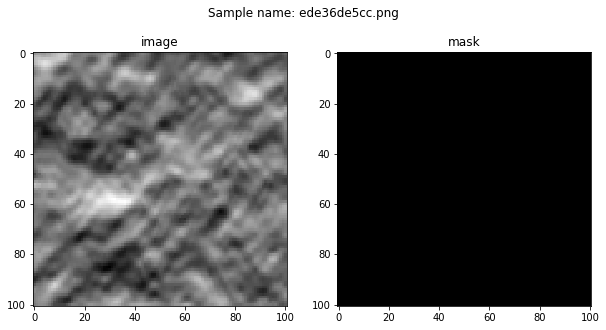

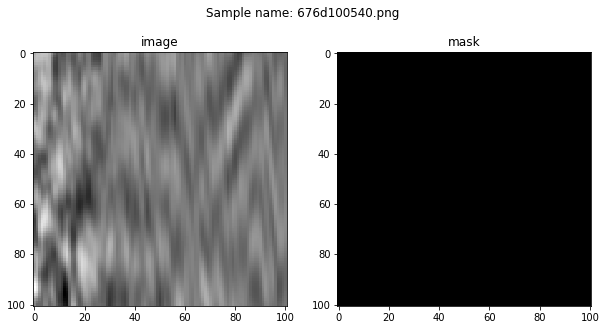

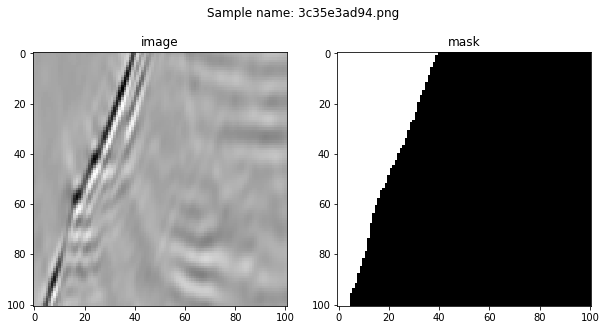

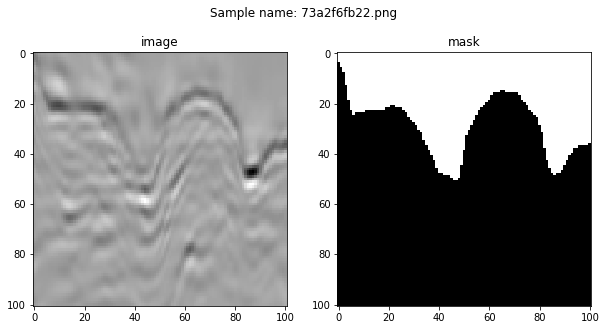

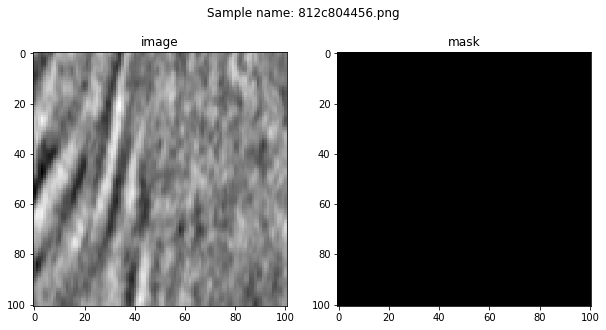

In [19]:
# plot randomly picked samples
plot_random_samples(root_train_path, number_of_samples = 5)

Eine Nachfrage bei einem Domänespezialisten ergab, dass außerdem fehlerhaft gelabelte Aufnahmen existieren.

Um bessere Ergebnisse erzielen zu können, können diese Aufnahmen ignoriert werden. In diesem Notebook wurde jedoch auf das Aussortieren verzichtet.

Die nachfolgend Plots zeigen beispielhaft zwei fehlerhaft gelabelte Aufnahmen.

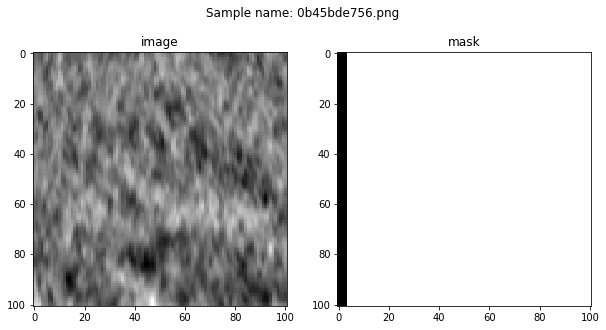

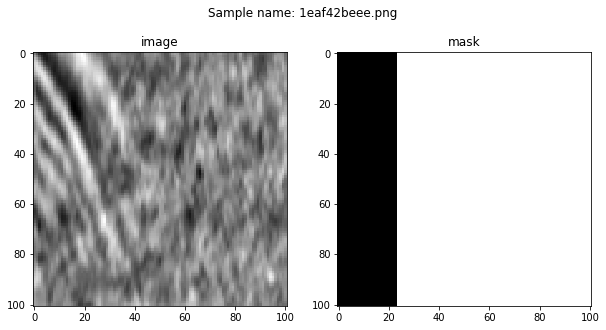

In [20]:
# plot incorrect labeled samples
plot_sample(root_train_path, "0b45bde756.png")
plot_sample(root_train_path, "1eaf42beee.png")

##Skalierung der Trainigsbilder und Masken

In [21]:
# package to transform images
from keras.preprocessing.image import img_to_array, load_img, array_to_img
# package to resize transformed images
from skimage.transform import resize
# package to show progress bar
from tqdm import tqdm


Using TensorFlow backend.


Eine Skalierung ist nötig, da U-Net lediglich mit Bilder umgehen kann, deren Seitenlängen (in Pixel) ohne Rest durch zwei teilbar sind (Grund: U-Net halbiert üblicherweise die Seitenlängen durch MaxPooling).

Die Methode "get_scaled_images_and_masks" soll alle Trainigsdaten (Bilder und Masken) aus einem Verzeichnis laden und diese auf das von U-Net gewünschte Format skalieren.

In [0]:
# get_scaled_images_and_masks arguments
# root_train_path     root path of the training data
# new_img_width       new image width
# new_img_height      new image height

def get_scaled_images_and_masks(root_train_path, new_img_width, new_img_height):
    print('Getting and resizing images ...')

    # size of the generated output image (rows, columns, dimension)
    output_shape = (new_img_width, new_img_height, 1) 

    # get list of names of all input images from image path
    ids = os.listdir(root_train_path + '/images')

    # get new arrays of given shape and type, filled with zeros
    X = np.zeros((len(ids), new_img_height, new_img_width, 1), dtype=np.float32)
    y = np.zeros((len(ids), new_img_height, new_img_width, 1), dtype=np.float32)
    
    # iterate through all images and masks and do resize operations
    for n, id_ in tqdm(enumerate(ids), total=len(ids)):

        # loads images and masks into PIL format
        imgs = load_img(root_train_path + '/images/' + id_, color_mode = "grayscale")
        masks = load_img(root_train_path + '/masks/' + id_, color_mode = "grayscale")

        # converts PIL images and masks instance to Numpy arrays
        imgs_np = img_to_array(imgs)
        masks_np = img_to_array(masks)

        # resize images and masks to the output shape an keep the original
        # range of values
        imgs_np_rz = resize(imgs_np, output_shape, mode='constant', preserve_range=True)        
        masks_np_rz = resize(masks_np, output_shape, mode='constant', preserve_range=True)

        # divide rgb value by 255 to get floating point value
        X[n, ..., 0] = imgs_np_rz.squeeze() / 255
        y[n] = masks_np_rz / 255

    print('Done!')    
    
    return X, y

Für die Bildgröße wird 128x128x1 gewählt, da dies dem Format entspricht, mit dem U-Net umgehen kann.

In [0]:
img_width = 128
img_height = 128
dimension = 1

Die Bilder und Masken werden skaliert und in X = Bilder und y = Masken gespeichert. X und y werden später in Trainigs-, Validierungs- und Testdaten geteilt.

In [24]:
# get all images and corresponding masks
X, y = get_scaled_images_and_masks(root_train_path, img_width, img_height)

Getting and resizing images ...


100%|██████████| 4000/4000 [00:12<00:00, 326.43it/s]

Done!


#Definition des U-Net-Netzwerks

##Evaluierungsmetrik

Als Evaluierungsmetrik wird Intersection over Union (IoU) gewählt. Die Tensorflow-Bibliothek stellt diese inkl. Loss-Funktion zur Verfügung.

In [0]:
# package to get accesss to IoU
import tensorflow as tf
# package to return loss and mean Iou tensor
from keras import backend as K

In [0]:
def mean_iou(y_true, y_pred):
    # list of precission values 
    prec = []

    # list of IoU thresholds
    thresholds = np.arange(0.5, 1.0, 0.025)

    # calculate mean IoU and loss for prediction
    for threshold in thresholds:
        y_pred_ = tf.cast(y_pred > threshold, tf.int32)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())

        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)

        prec.append(score)

    # return loss and mean IoU
    return K.mean(K.stack(prec), axis=0)

##Architektur

Nachfolgend wird die Architektur von U-Net (siehe Kapitel "U-Net in der Theorie -> Überblick") mit Hilfe von Keras modelliert.

In [0]:
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

Die Funktion "conv2d_block" fasst zwei Convolution-Schichten zusammen, da diese in jeder Ebene (Decoder und Encoder) wiederverwendet werden kann.

In [0]:
# conv2d_block arguments
# input_img       input image that will be processes by the convolution layer
# n_filters       number of filter that will be used
# kernel_size     size of the kernel
# batchnorm       whether or not batchnormalization will be used

def conv2d_block(input_img, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, 
               kernel_size=(kernel_size, kernel_size), 
               kernel_initializer="he_normal",
               padding="same")(input_img)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)

    # second layer
    x = Conv2D(filters=n_filters, 
               kernel_size=(kernel_size, kernel_size), 
               kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

Die Funktion "get_unet" gibt ein U-Net Modell gemäß den Übergabeparametern zurück.

In [0]:
# get_unet arguments
# input_img               input image that will be processes by the convolution 
#                         layer
# n_filters               number of filter that will be used
# dropout                 factor od dropout
# batchnorm               whether or not batchnormalization will be used
# use_skip_connections    whether or not skip connections will be turned on

def get_unet(input_img, n_filters = 16, dropout= 0.5, batchnorm = True, use_skip_connections = True):

    ###### contracting path (decoder) ######

    ### top-level ###
    # two convolution layer
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    # image shrink (but increase number of featuremaps)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    ### second highest level ###
    # two convolution layer
    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    ### third highest level ###
    # two convolution layer
    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    # image shrink (but increase number of featuremaps)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    ### second lowest level ###
    # two convolution layer
    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    # image shrink (but increase number of featuremaps)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    ### lowest level ###
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    ###### expansive path (encoder) ######

    ### second lowest level ###
    # enlarge image
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    if use_skip_connections == True:
      # skip connection
      u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    # two convolution layer
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    ### third highest level ###
    # enlarge image
    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    if use_skip_connections == True:
      # skip connection
      u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    # two convolution layer
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    ### second highest level ###
    # enlarge image
    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    if use_skip_connections == True:
      # skip connection
      u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    # two convolution layer
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    ### top-level ###
    # enlarge image
    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    if use_skip_connections == True:
      # skip connection
      u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    # two convolution layer
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    # reduce featuremaps
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[input_img], outputs=[outputs])

    return model

Es werden vier U-Net Modelle definiert und anschließend kompiliert. Es gilt:

- model_std = Modell, das sehr nahe an die Standard-Implementierung heranreicht (Ausnahme: Batchnormalization)
- model_std_no_skip = wie model_std aber ohne Skip-Connections
- model_h_flip = wie model_std aber mit Data Augmentation (Bilder und Masken horizontal gespiegelt)
- model_v_flip = wie model_std aber mit Data Augmentation (Bilder und Masken vertikal gespiegelt)

In [30]:
# define input image layer
input_img = Input((img_width, img_height, dimension), name='img')

# get u-net-model
model_std = get_unet(
    input_img, 
    n_filters = 16, 
    dropout = 0.05, 
    batchnorm = True, 
    use_skip_connections = True)

model_std_no_skip = get_unet(
    input_img, 
    n_filters = 16, 
    dropout = 0.05, 
    batchnorm = True, 
    use_skip_connections = False)

model_h_flip = get_unet(
    input_img, 
    n_filters = 16, 
    dropout = 0.05, 
    batchnorm = True, 
    use_skip_connections = True)

model_v_flip = get_unet(
    input_img, 
    n_filters = 16, 
    dropout = 0.05, 
    batchnorm = True, 
    use_skip_connections = True)

# compile u-net-model
model_std.compile(
    optimizer=Adam(), 
    loss="binary_crossentropy", 
    metrics=[mean_iou])

model_std_no_skip.compile(
    optimizer=Adam(), 
    loss="binary_crossentropy", 
    metrics=[mean_iou])

model_h_flip.compile(
    optimizer=Adam(), 
    loss="binary_crossentropy", 
    metrics=[mean_iou])

model_v_flip.compile(
    optimizer=Adam(), 
    loss="binary_crossentropy", 
    metrics=[mean_iou])

# print out standard model to check if it looks alright
model_std.summary()













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 16) 64          conv2d_1[0][0]        

#Training der U-Net-Modelle

Die vier Modelle werden nun trainiert. Um u.a. Overfitting zu vermeiden werden s.g. Callbacks definiert, die das Training vorzeitig beenden.

Das Vorgehen ist bei allen vier Modellen nahezu das selbe:
- Callbacks definieren
- Generator für Data Augmentation definieren (nicht für std und std_no_skip)
- Modell trainieren

## Plot-Funktionen

In [0]:
# plot_learning_curve arguments
# fit_results     prediction 

def plot_learning_curve(fit_results):
    plt.figure(figsize=(8, 8))
    plt.title("Learning curve")
    plt.plot(fit_results.history["loss"], label="loss")
    plt.plot(fit_results.history["val_loss"], label="val_loss")
    plt.plot( np.argmin(fit_results.history["val_loss"]), np.min(fit_results.history["val_loss"]), marker="x", color="r", label="best model")
    plt.xlabel("Epochs")
    plt.ylabel("log_loss")
    plt.legend();

##Data Augmentation

Mit Hilfe von Data Augmentation kann eine bessere Vorhersage (mean_IoU) erreicht werden. 

In [0]:
# package to do data augmentation
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img 

In [0]:
# plot_learning_curve arguments
# X                     original image
# y                     original mask
# do_horizontal_flip    whether or not do horizontal flip
# do_vertical_flip      whether or not do vertical flip
# seed                  seed to be able to reproduce data augmentation
# batch_size            batch size

def get_image_mask_generator(X, y, 
                             do_horizontal_flip = False, 
                             do_vertical_flip = False, 
                             seed = 1234, 
                             batch_size = 32):
    
    # define dictionary with data augmentation settings
    data_gen_args = {
        "horizontal_flip" : do_horizontal_flip, 
        "vertical_flip" : do_vertical_flip}

    # generate batches of tensor image data with real-time data augmentation
    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)

    # takes image & mask arrays, generate batches of augmented data
    image_generator = image_datagen.flow(X, seed=seed, batch_size = batch_size, shuffle = True)
    mask_generator = mask_datagen.flow(y, seed=seed, batch_size = batch_size, shuffle = True)

    # zip the two generators to get a generator that provides augmented images and masks at the same time
    image_mask_generator = zip(image_generator, mask_generator)

    return image_mask_generator

##Train-, Test-, Valid-Split

Bevor die Daten gesplittet werden ist es notwendig, welche Informationen wie im Datensatz verteilt sind. Folgendes Szenario (worst case):
- Daten werden in Trainings-, Validierungs- und Testdaten gesplittet
- Trainingsdaten: enthalten lediglich Bilder, in denen kein Salz enthalten ist
- Validierungsdaten: enthalten lediglich Bilder, in denen kein Salz enthalten ist
- Testdaten: enthalten alle Bilder, in denen Salz enthalten ist

Um dieser ungleiche Verteilung vorzubeugen bietet es sich an die Daten zuvor in Klassen (gemäß ihrem Salzgehalt) einzuteilen. Mit Hilfe der Klasseninformation kann dann ein gerechtes Splitting erfolgen.

In [0]:
# package for data preprocessing 
import pandas as pd

In [0]:
# container for coverage class and temporary data
dataset_complete = pd.DataFrame({})

# list of file names
dataset_complete_names = os.listdir(root_train_path + '/masks')

In [36]:
# set the image to grayscale and divid it by 255 to normalize gray-values within 0 to 1 range
dataset_complete["mask_array"] = [np.array(load_img(path=(root_train_path + "/masks/" + file_name), color_mode="grayscale")) / 255 for file_name in tqdm(dataset_complete_names)]

100%|██████████| 4000/4000 [00:01<00:00, 3877.15it/s]


In [0]:
# calculate salt coverage of each image
dataset_complete["coverage"] = dataset_complete.mask_array.map(np.sum) / (img_width * img_height)

In [0]:
# package to plot distribution of salt coverage
import seaborn as sns

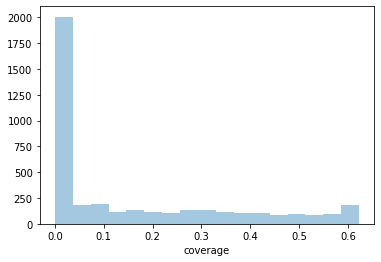

In [39]:
# plot distribution
sns.distplot(dataset_complete.coverage, kde=False)

Es stehen insgesamt 4000 gelabelte Aufnahmen zur Verfügung.
Die Daten werden wie folgt zerlegt:
- Trainingsdaten (70%) 
- Validierungsdaten (20%)
- Testdaten (10%)

###Train-/Valid-, Test-Split

In [0]:
# coverage_to_class arguments
# coverage    value of salt coverage     

def coverage_to_class(coverage):    
    for coverage_class in range(0, 11):
        # calculate class by value of coverage
        if coverage * 10 <= coverage_class :
            return coverage_class

In [0]:
# calculate coverage class
dataset_complete["coverage_class"] = dataset_complete.coverage.map(coverage_to_class)

4000 Masken sind nun in Klassen von 1 bis 10 eingeteilt (Labels für die Split-Operation)

In [42]:
dataset_complete.coverage_class

0       1
1       3
2       4
3       0
4       0
       ..
3995    5
3996    0
3997    0
3998    1
3999    1
Name: coverage_class, Length: 4000, dtype: int64

In [0]:
# package to split data
from sklearn.model_selection import train_test_split

In [0]:
# seed for train/valid and test split
random_state_seed_tv_t = 1234

# split X and y into random train_valid and test
X_train_valid, X_test, y_train_valid, y_test = train_test_split(
    X, 
    y, 
    test_size = 0.10,
    stratify = dataset_complete.coverage_class,
    random_state = random_state_seed_tv_t)

###Train-, Valid-Split

In [0]:
# container for coverage class and temporary data
dataset_train_valid = pd.DataFrame({})

In [46]:
# use y_train_valid to detect new class distribution
dataset_train_valid["mask_array"] = [np.reshape(sample, (img_width, img_height)) for sample in tqdm(y_train_valid)]

100%|██████████| 3600/3600 [00:00<00:00, 418895.15it/s]


In [0]:
# calculate salt coverage of each image (lost distribution information because of first split operation)
dataset_train_valid["coverage"] = dataset_train_valid.mask_array.map(np.sum) / (img_width * img_height)

Die Verteilung sollte sich nun geringfügig geändert haben, da die Testdaten lediglich einen Anteil von 10% des kompletten Datensatzen erhalten haben.

Dies ist hier der Fall. 

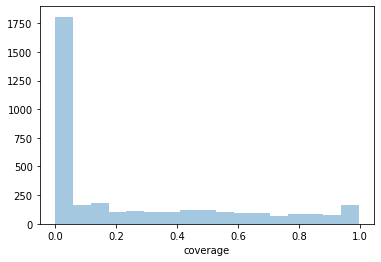

In [48]:
# plot distribution
sns.distplot(dataset_train_valid.coverage, kde=False)

In [0]:
# calculate coverage class
dataset_train_valid["coverage_class"] = dataset_train_valid.coverage.map(coverage_to_class)

3600 Masken sind nun in Klassen von 1 bis 10 eingeteilt (Labels für die Split-Operation)

In [50]:
dataset_train_valid.coverage_class

0        1
1        0
2        2
3        0
4       10
        ..
3595     1
3596     1
3597     1
3598     2
3599     1
Name: coverage_class, Length: 3600, dtype: int64

In [0]:
# seed for train, valid and test split
random_state_seed_t_v_t = 2345

# Split X_train_valid and y_train_valid into random train and valid
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_valid, 
    y_train_valid, 
    test_size = 0.222,
    stratify = dataset_train_valid.coverage_class,
    random_state = random_state_seed_t_v_t)

###Evaluierung

Die Verteilung der Trainings-, Validierungs- und Testdaten sollten nun nahezu identisch aussehen.

In [0]:
# container for coverage class and temporary data
dataset_train = pd.DataFrame({})
dataset_valid = pd.DataFrame({})
dataset_test = pd.DataFrame({})

In [53]:
# use y_train, y_valid and y_test to detect class distribution
dataset_train["mask_array"] = [np.reshape(sample, (img_width, img_height)) for sample in tqdm(y_train)]
dataset_valid["mask_array"] = [np.reshape(sample, (img_width, img_height)) for sample in tqdm(y_valid)]
dataset_test["mask_array"] = [np.reshape(sample, (img_width, img_height)) for sample in tqdm(y_test)]

100%|██████████| 400/400 [00:00<00:00, 247634.18it/s]


In [0]:
# calculate salt coverage of each image (lost distribution information because of first split operation)
dataset_train["coverage"] = dataset_train.mask_array.map(np.sum) / (img_width * img_height)
dataset_valid["coverage"] = dataset_train.mask_array.map(np.sum) / (img_width * img_height)
dataset_test["coverage"] = dataset_train.mask_array.map(np.sum) / (img_width * img_height)

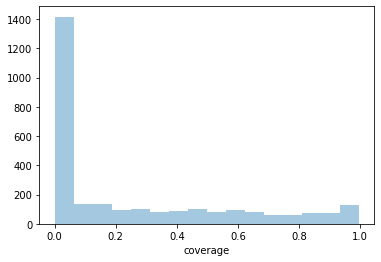

In [55]:
# train
sns.distplot(dataset_train.coverage, kde=False, label="train")

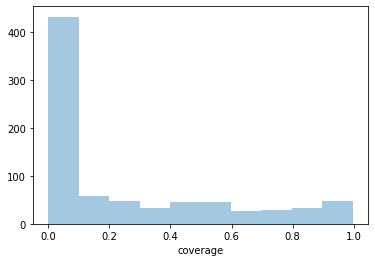

In [56]:
# valid
sns.distplot(dataset_valid.coverage, kde=False, label="valid")

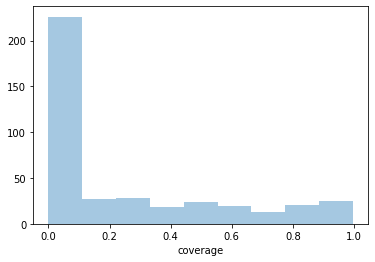

In [57]:
# test
sns.distplot(dataset_test.coverage, kde=False, label = "test")

##U-Net-Modell ohne Data Augmentation (std)

In [0]:
# packages to define callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [0]:
# EarlyStopping arguments
# patience            number of epochs that produced the monitored quantity with
#                     no improvement after which training will be stopped
# verbose             0 = silent, 1 = progress bar, 2 = one line per epoch

# ReduceLROnPlateau arguments
# factor              factor by which the learning rate will be reduced
#                     new_lr = lr * factor
# patience            number of epochs that produced the monitored quantity with
#                     no improvement after which training will be stopped
# min_lr              lower bound on the learning rate
# verbose             0 = silent, 1 = progress bar, 2 = one line per epoch

# ModelCheckpoint arguments
# filepath            path to save the model file
# verbose             0 = silent, 1 = progress bar, 2 = one line per epoch
# save_best_only      if save_best_only=True, the latest best model according 
#                     to the quantity monitored will not be overwritten
# save_weights_only   if True, then only the model's weights will be saved

filepath_std = 'model_std.h5'

callbacks_std = [
    EarlyStopping(
        patience = 10, 
        verbose = 1),
    ReduceLROnPlateau(
        factor = 0.1, 
        patience = 3, 
        min_lr = 0.000001, 
        verbose = 1),
    ModelCheckpoint(
        filepath_std, 
        verbose=1, 
        save_best_only=True, 
        save_weights_only=True)
]

In [60]:
# fit arguments
# x                 input data
# y                 target data
# batch_size        number of samples that will be propagated through the network
#                   (take the first batch_size samples from the training set and
#                   train the network, next, take the second batch_size_samples)
# epochs            number of epochs to train the model(an epoch is an iteration
#                   over the entire x and y data provided)
# callbacks         list of Callback instances to applay during training and
#                   validation
# validation_data   data on which to evaluate the loss and any model metrics at 
#                   the end of each epoch

# set parameter to fit model
batch_size_std = 32
epochs_std = 100

# fit the model
results_std = model_std.fit(
    X_train, 
    y_train,
    batch_size=batch_size_std, 
    epochs=epochs_std, 
    callbacks=callbacks_std,
    validation_data=(X_valid, y_valid))



Train on 2800 samples, validate on 800 samples
Epoch 1/100
2800/2800 [==============================] - 24s 8ms/step - loss: 0.4050 - mean_iou: 0.4770 - val_loss: 0.7906 - val_mean_iou: 0.5511

Epoch 00001: val_loss improved from inf to 0.79057, saving model to model_std.h5
Epoch 2/100
2800/2800 [==============================] - 9s 3ms/step - loss: 0.3017 - mean_iou: 0.5773 - val_loss: 0.3859 - val_mean_iou: 0.5991

Epoch 00002: val_loss improved from 0.79057 to 0.38591, saving model to model_std.h5
Epoch 3/100
2800/2800 [==============================] - 9s 3ms/step - loss: 0.2645 - mean_iou: 0.6157 - val_loss: 0.4287 - val_mean_iou: 0.6298

Epoch 00003: val_loss did not improve from 0.38591
Epoch 4/100
2800/2800 [==============================] - 9s 3ms/step - loss: 0.2540 - mean_iou: 0.6399 - val_loss: 0.3310 - val_mean_iou: 0.6502

Epoch 00004: val_loss improved from 0.38591 to 0.33100, saving model to model_std.h5
Epoch 5/100
2800/2800 [==============================] - 9s 3ms/

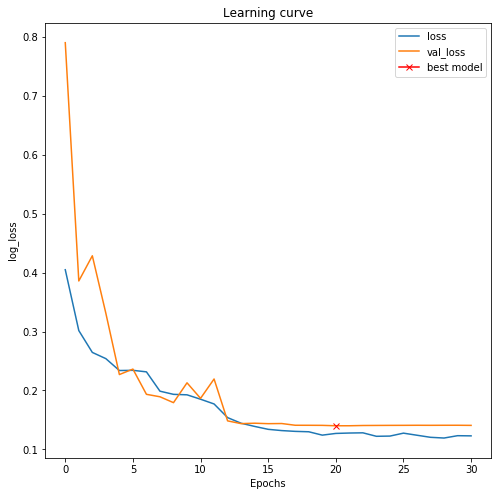

In [61]:
plot_learning_curve(results_std)

##U-Net-Modell ohne Data Augmentation und ohne Skip-Connections (std_no_skip)

In [0]:
# EarlyStopping arguments
# patience            number of epochs that produced the monitored quantity with
#                     no improvement after which training will be stopped
# verbose             0 = silent, 1 = progress bar, 2 = one line per epoch

# ReduceLROnPlateau arguments
# factor              factor by which the learning rate will be reduced
#                     new_lr = lr * factor
# patience            number of epochs that produced the monitored quantity with
#                     no improvement after which training will be stopped
# min_lr              lower bound on the learning rate
# verbose             0 = silent, 1 = progress bar, 2 = one line per epoch

# ModelCheckpoint arguments
# filepath            path to save the model file
# verbose             0 = silent, 1 = progress bar, 2 = one line per epoch
# save_best_only      if save_best_only=True, the latest best model according 
#                     to the quantity monitored will not be overwritten
# save_weights_only   if True, then only the model's weights will be saved

# parameter to fit model
filepath_std_no_skip = 'model_std_no_skip.h5'

callbacks_std_no_skip = [
    EarlyStopping(
        patience = 10, 
        verbose = 1),
    ReduceLROnPlateau(
        factor = 0.1, 
        patience = 3, 
        min_lr = 0.000001, 
        verbose = 1),
    ModelCheckpoint(
        filepath_std_no_skip, 
        verbose = 1, 
        save_best_only = True, 
        save_weights_only = True)
]

In [63]:
# fit arguments
# x                 input data
# y                 target data
# batch_size        number of samples that will be propagated through the network
#                   (take the first batch_size samples from the training set and
#                   train the network, next, take the second batch_size_samples)
# epochs            number of epochs to train the model(an epoch is an iteration
#                   over the entire x and y data provided)
# callbacks         list of Callback instances to applay during training and
#                   validation
# validation_data   data on which to evaluate the loss and any model metrics at 
#                   the end of each epoch

# set parameter to fit model
batch_size_std_no_skip = batch_size_std
epochs_std_no_skip = epochs_std

# fit the model
results_std_no_skip = model_std_no_skip.fit(
    X_train, 
    y_train, 
    batch_size=batch_size_std_no_skip, 
    epochs=epochs_std_no_skip, 
    callbacks=callbacks_std_no_skip,
    validation_data=(X_valid, y_valid))

Train on 2800 samples, validate on 800 samples
Epoch 1/100
2800/2800 [==============================] - 16s 6ms/step - loss: 0.4338 - mean_iou: 0.4922 - val_loss: 0.4207 - val_mean_iou: 0.5730

Epoch 00001: val_loss improved from inf to 0.42074, saving model to model_std_no_skip.h5
Epoch 2/100
2800/2800 [==============================] - 8s 3ms/step - loss: 0.3105 - mean_iou: 0.6020 - val_loss: 0.4741 - val_mean_iou: 0.6215

Epoch 00002: val_loss did not improve from 0.42074
Epoch 3/100
2800/2800 [==============================] - 8s 3ms/step - loss: 0.2857 - mean_iou: 0.6339 - val_loss: 0.4908 - val_mean_iou: 0.6445

Epoch 00003: val_loss did not improve from 0.42074
Epoch 4/100
2800/2800 [==============================] - 8s 3ms/step - loss: 0.2568 - mean_iou: 0.6532 - val_loss: 0.3182 - val_mean_iou: 0.6603

Epoch 00004: val_loss improved from 0.42074 to 0.31823, saving model to model_std_no_skip.h5
Epoch 5/100
2800/2800 [==============================] - 8s 3ms/step - loss: 0.2473 

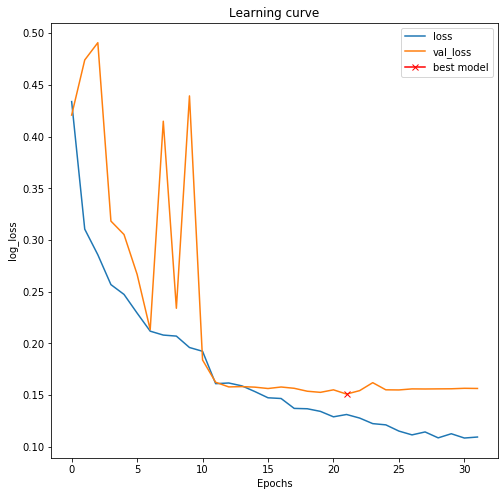

In [64]:
plot_learning_curve(results_std_no_skip)

##U-Net-Modell mit Data Augmentation (h-Flip)

In [0]:
# EarlyStopping arguments
# patience            number of epochs that produced the monitored quantity with
#                     no improvement after which training will be stopped
# verbose             0 = silent, 1 = progress bar, 2 = one line per epoch

# ReduceLROnPlateau arguments
# factor              factor by which the learning rate will be reduced
#                     new_lr = lr * factor
# patience            number of epochs that produced the monitored quantity with
#                     no improvement after which training will be stopped
# min_lr              lower bound on the learning rate
# verbose             0 = silent, 1 = progress bar, 2 = one line per epoch

# ModelCheckpoint arguments
# filepath            path to save the model file
# verbose             0 = silent, 1 = progress bar, 2 = one line per epoch
# save_best_only      if save_best_only=True, the latest best model according 
#                     to the quantity monitored will not be overwritten
# save_weights_only   if True, then only the model's weights will be saved

# set parameter to fit model
filepath_h_flip = 'model_h_flip.h5'

# fit the model
callbacks_h_flip = [
    EarlyStopping(
        patience = 10, 
        verbose = 1),
    ReduceLROnPlateau(
        factor = 0.1, 
        patience = 3, 
        min_lr = 0.000001, 
        verbose = 1),
    ModelCheckpoint(
        filepath_h_flip, 
        verbose = 1, 
        save_best_only = True, 
        save_weights_only = True)
]

In [0]:
# set seed to be able to reproduce results
seed_h_flip = 1234
batch_size_h_flip = batch_size_std

train_generator_h_flip = get_image_mask_generator(
    X_train, 
    y_train, 
    do_horizontal_flip = True, 
    do_vertical_flip = False, 
    seed = seed_h_flip, 
    batch_size = batch_size_h_flip)

valid_generator_h_flip = get_image_mask_generator(
    X_valid, 
    y_valid, 
    do_horizontal_flip = True, 
    do_vertical_flip = False, 
    seed = seed_h_flip, 
    batch_size = batch_size_h_flip)

In [67]:
# fit_generator arguments
# generator         train generator
# steps_per_epoch   total number of steps (batches of samples) to yield from
#                   generator before declaring one epoch finished and starting 
#                   the next epoch
# epochs            number of epochs to train the model(an epoch is an iteration
#                   over the entire x and y data provided)
# callbacks         list of Callback instances to applay during training and
#                   validation
# validation_data   data on which to evaluate the loss and any model metrics at 
#                   the end of each epoch

# set parameter to fit model
steps_per_epoch_h_flip = (len(X_train) // batch_size_h_flip)
epochs_h_flip = epochs_std
validation_steps_h_flip = (len(X_valid) // batch_size_h_flip)

# fit the model
results_h_flip = model_h_flip.fit_generator(
    train_generator_h_flip, 
    steps_per_epoch = steps_per_epoch_h_flip, 
    epochs = epochs_h_flip,
    callbacks = callbacks_h_flip,
    validation_steps = validation_steps_h_flip,
    validation_data = valid_generator_h_flip)

Epoch 1/100
87/87 [==============================] - 18s 204ms/step - loss: 0.3946 - mean_iou: 0.4896 - val_loss: 0.6351 - val_mean_iou: 0.5736

Epoch 00001: val_loss improved from inf to 0.63510, saving model to model_h_flip.h5
Epoch 2/100
87/87 [==============================] - 9s 101ms/step - loss: 0.2959 - mean_iou: 0.5994 - val_loss: 0.4837 - val_mean_iou: 0.6229

Epoch 00002: val_loss improved from 0.63510 to 0.48374, saving model to model_h_flip.h5
Epoch 3/100
87/87 [==============================] - 9s 100ms/step - loss: 0.2654 - mean_iou: 0.6373 - val_loss: 0.3178 - val_mean_iou: 0.6492

Epoch 00003: val_loss improved from 0.48374 to 0.31782, saving model to model_h_flip.h5
Epoch 4/100
87/87 [==============================] - 9s 101ms/step - loss: 0.2547 - mean_iou: 0.6566 - val_loss: 0.5962 - val_mean_iou: 0.6632

Epoch 00004: val_loss did not improve from 0.31782
Epoch 5/100
87/87 [==============================] - 9s 100ms/step - loss: 0.2441 - mean_iou: 0.6686 - val_loss:

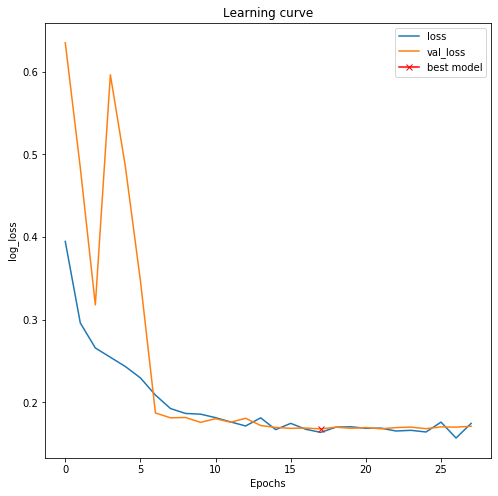

In [68]:
plot_learning_curve(results_h_flip)

##U-Net-Modell mit Data Augmentation (v-Flip)

In [0]:
# EarlyStopping arguments
# patience            number of epochs that produced the monitored quantity with
#                     no improvement after which training will be stopped
# verbose             0 = silent, 1 = progress bar, 2 = one line per epoch

# ReduceLROnPlateau arguments
# factor              factor by which the learning rate will be reduced
#                     new_lr = lr * factor
# patience            number of epochs that produced the monitored quantity with
#                     no improvement after which training will be stopped
# min_lr              lower bound on the learning rate
# verbose             0 = silent, 1 = progress bar, 2 = one line per epoch

# ModelCheckpoint arguments
# filepath            path to save the model file
# verbose             0 = silent, 1 = progress bar, 2 = one line per epoch
# save_best_only      if save_best_only=True, the latest best model according 
#                     to the quantity monitored will not be overwritten
# save_weights_only   if True, then only the model's weights will be saved

filepath_v_flip = 'model_v_flip.h5'

callbacks_v_flip = [
    EarlyStopping(
        patience = 10, 
        verbose = 1),
    ReduceLROnPlateau(
        factor = 0.1, 
        patience = 3, 
        min_lr = 0.000001, 
        verbose = 1),
    ModelCheckpoint(
        filepath_v_flip, 
        verbose = 1, 
        save_best_only = True, 
        save_weights_only = True)
]

In [0]:
# set parameter to fit model
seed_v_flip = seed_h_flip
batch_size_v_flip = batch_size_h_flip

# fit the model
train_generator_v_flip = get_image_mask_generator(
    X_train, 
    y_train, 
    do_horizontal_flip = False, 
    do_vertical_flip = True, 
    seed = seed_v_flip, 
    batch_size = batch_size_v_flip)

valid_generator_v_flip = get_image_mask_generator(
    X_valid, 
    y_valid, 
    do_horizontal_flip = False, 
    do_vertical_flip = True, 
    seed = seed_v_flip, 
    batch_size = batch_size_v_flip)

In [71]:
# fit_generator arguments
# generator         train generator
# steps_per_epoch   total number of steps (batches of samples) to yield from
#                   generator before declaring one epoch finished and starting 
#                   the next epoch
# epochs            number of epochs to train the model(an epoch is an iteration
#                   over the entire x and y data provided)
# callbacks         list of Callback instances to applay during training and
#                   validation
# validation_data   data on which to evaluate the loss and any model metrics at 
#                   the end of each epoch

# set parameter to fit model
steps_per_epoch_v_flip = (len(X_train) // batch_size_v_flip)
epochs_v_flip = epochs_std
validation_steps_v_flip = (len(X_valid) // batch_size_v_flip)

# fit the model
results_v_flip = model_v_flip.fit_generator(
    train_generator_v_flip, 
    steps_per_epoch = steps_per_epoch_v_flip, 
    epochs = epochs_v_flip,
    callbacks = callbacks_v_flip,
    validation_steps = validation_steps_v_flip,
    validation_data = valid_generator_v_flip)

Epoch 1/100
87/87 [==============================] - 19s 214ms/step - loss: 0.5370 - mean_iou: 0.4569 - val_loss: 1.0887 - val_mean_iou: 0.5226

Epoch 00001: val_loss improved from inf to 1.08869, saving model to model_v_flip.h5
Epoch 2/100
87/87 [==============================] - 9s 100ms/step - loss: 0.3643 - mean_iou: 0.5411 - val_loss: 0.6610 - val_mean_iou: 0.5591

Epoch 00002: val_loss improved from 1.08869 to 0.66095, saving model to model_v_flip.h5
Epoch 3/100
87/87 [==============================] - 9s 102ms/step - loss: 0.3163 - mean_iou: 0.5754 - val_loss: 0.4249 - val_mean_iou: 0.5888

Epoch 00003: val_loss improved from 0.66095 to 0.42486, saving model to model_v_flip.h5
Epoch 4/100
87/87 [==============================] - 9s 102ms/step - loss: 0.2987 - mean_iou: 0.5984 - val_loss: 0.4851 - val_mean_iou: 0.6076

Epoch 00004: val_loss did not improve from 0.42486
Epoch 5/100
87/87 [==============================] - 9s 101ms/step - loss: 0.2937 - mean_iou: 0.6150 - val_loss:

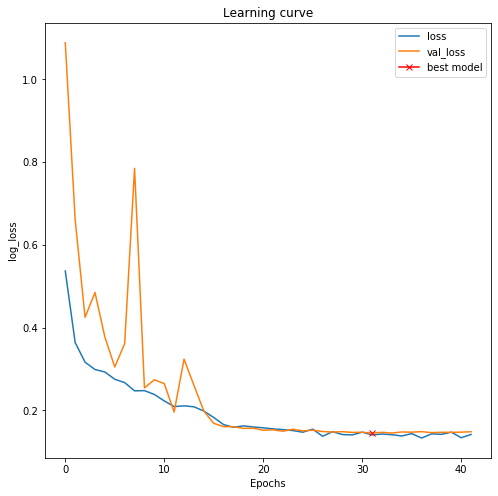

In [72]:
plot_learning_curve(results_v_flip)

#Evaluation der U-Net-Modelle

Die vier Modelle werden nun evaluiert.

Das Vorgehen ist bei allen vier Modellen nahezu das selbe:
- Evaluation (Trainings-, Validierungs- und Testdaten)
- Optimierung des Thresholds für die binäre Vorhersage
- Ausgabe einer zufälliger Vorhersage (Trainings-, Validierungs- und Testdaten)

##Plot-Funktionen

In [0]:
# package to generate random numbers
import random

In [0]:
# plot_prediction arguments
# X               original image
# y               original mask
# preds           prediction
# binary_preds    binary prediction
# ix              number of image to plot

def plot_prediction(X, y, preds, binary_preds, ix = None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    fig.suptitle("\n".join(["Sample no.: % 2d" %(ix)]), y=0.75)

    # input
    ax[0].imshow(X[ix, ..., 0], cmap = 'gray')
    ax[0].set_title('Input')

    # ground truth
    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Ground truth')

    # predicted
    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='red', levels=[0.5])
    ax[2].set_title('Predicted')
    
    # predicted binary
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='red', levels=[0.5])
    ax[3].set_title('Predicted binary');

In [0]:
# plot_sample arguments
# X               original image
# y               original mask
# preds           prediction
# binary_preds    binary prediction
# ix              number of image to plot

def plot_thresholds(thresholds, threshold_best, ious, iou_best):
    plt.plot(thresholds, ious)
    plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
    plt.xlabel("Threshold")
    plt.ylabel("IoU")
    plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
    plt.legend()

##Threshold-Optimierung

In [0]:
from tqdm import tqdm_notebook

In [0]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(
        labels.flatten(), 
        y_pred.flatten(), 
        bins = (true_objects, pred_objects))[0]

    # compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # compute union
    union = area_true + area_pred - intersection

    # exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # compute the intersection over union
    iou = intersection / union

    # precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

##U-Net-Modell ohne Data Augmentation (std)

###Evaluation

In [0]:
# load best model
model_std.load_weights(filepath_std)

In [79]:
# evaluate on train set
model_std_eva_train = model_std.evaluate(X_train, y_train, verbose=1)

2800/2800 [==============================] - 4s 2ms/step


In [80]:
# evaluate on validation set
model_std_eva_valid = model_std.evaluate(X_valid, y_valid, verbose=1)

800/800 [==============================] - 1s 2ms/step


In [81]:
# evaluate on test set
model_std_eva_test = model_std.evaluate(X_test, y_test, verbose=1)

400/400 [==============================] - 1s 2ms/step


In [82]:
# predict on train, val and test
preds_train_std = model_std.predict(X_train, verbose=1)
preds_val_std = model_std.predict(X_valid, verbose=1)
preds_test_std = model_std.predict(X_test, verbose=1)

400/400 [==============================] - 0s 681us/step


###Threshold-Optimierung

In [83]:
# set thresholds to test with predictions
thresholds_std = np.linspace(0, 1 ,50)

# calculate IoUs for each threshold
ious_std = np.array(
    [iou_metric_batch(y_valid, np.int32(preds_val_std > threshold)) 
    for threshold in tqdm_notebook(thresholds_std)])

In [0]:
# get index ob best threshold
threshold_best_index_std = np.argmax(ious_std[9:-10]) + 9

# get best IoU from all calculated IoUs
iou_best_std = ious_std[threshold_best_index_std]

# get best value of threshold
threshold_best_std = thresholds_std[threshold_best_index_std]

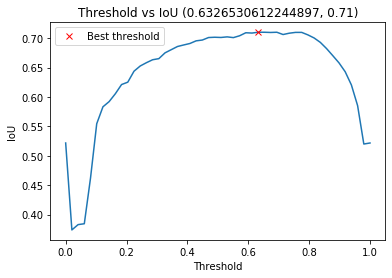

In [85]:
plot_thresholds(thresholds_std, 
                threshold_best_std, 
                ious_std, iou_best_std)

In [0]:
# get binary prediction with optimized thresholds
preds_train_t_std = (preds_train_std > threshold_best_std).astype(np.uint8)
preds_val_t_std = (preds_val_std > threshold_best_std).astype(np.uint8)
preds_test_t_std = (preds_test_std > threshold_best_std).astype(np.uint8)

###Beispielhafte Ausgabe der Vorhersagen

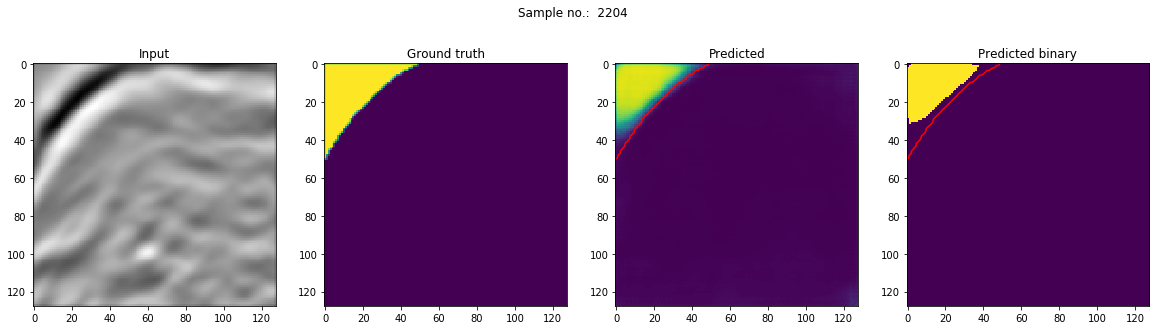

In [87]:
# check if training data looks all right
plot_prediction(X_train, y_train, preds_train_std, preds_train_t_std)

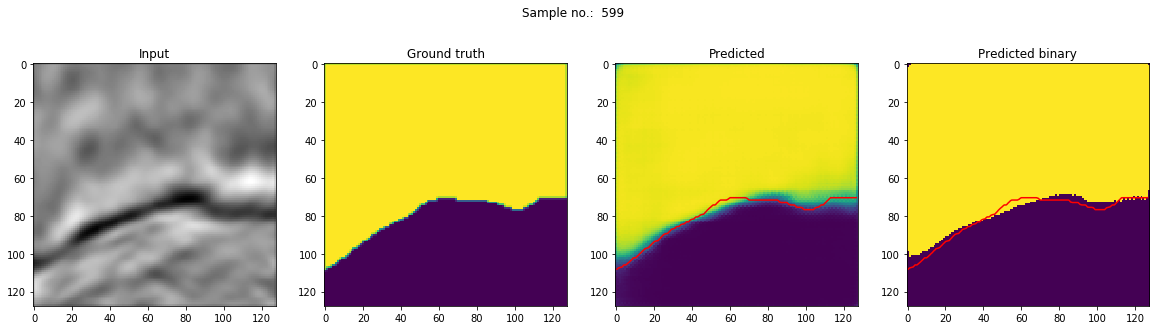

In [88]:
# check if valid data looks all right
plot_prediction(X_valid, y_valid, preds_val_std, preds_val_t_std)

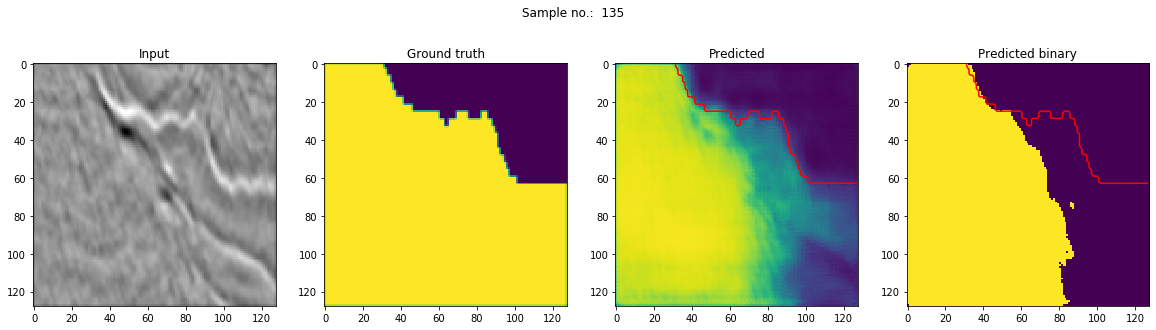

In [89]:
# check if valid data looks all right
plot_prediction(X_test, y_test, preds_test_std, preds_test_t_std)

##U-Net-Modell ohne Data Augmentation und ohne Skip-Connections (std_no_skip)

###Evaluation

In [0]:
# Load best model
model_std_no_skip.load_weights(filepath_std_no_skip)

In [91]:
# Evaluate on train set
model_std_no_skip_eva_train = model_std_no_skip.evaluate(X_train, y_train, verbose=1)

2800/2800 [==============================] - 5s 2ms/step


In [92]:
# Evaluate on validation set
model_std_no_skip_eva_valid = model_std_no_skip.evaluate(X_valid, y_valid, verbose=1)

800/800 [==============================] - 1s 2ms/step


In [93]:
# Evaluate on validation set
model_std_no_skip_eva_test = model_std_no_skip.evaluate(X_test, y_test, verbose=1)

400/400 [==============================] - 1s 2ms/step


In [94]:
# Predict on train, val and test
preds_train_std_no_skip = model_std_no_skip.predict(X_train, verbose=1)
preds_val_std_no_skip = model_std_no_skip.predict(X_valid, verbose=1)
preds_test_std_no_skip = model_std_no_skip.predict(X_test, verbose=1)

400/400 [==============================] - 0s 622us/step


###Threshold-Optimierung

In [95]:
thresholds_std_no_skip = np.linspace(0, 1 ,50)

ious_std_no_skip = np.array([iou_metric_batch(y_valid, np.int32(preds_val_std_no_skip > threshold)) for threshold in tqdm_notebook(thresholds_std_no_skip)])

In [0]:
threshold_best_index_std_no_skip = np.argmax(ious_std_no_skip[9:-10]) + 9
iou_best_std_no_skip = ious_std_no_skip[threshold_best_index_std_no_skip]
threshold_best_std_no_skip = thresholds_std_no_skip[threshold_best_index_std_no_skip]

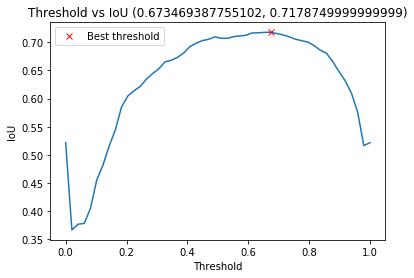

In [97]:
plot_thresholds(thresholds_std_no_skip, threshold_best_std_no_skip, ious_std_no_skip, iou_best_std_no_skip)

In [0]:
# Threshold predictions
preds_train_t_std_no_skip = (preds_train_std_no_skip > threshold_best_std_no_skip).astype(np.uint8)
preds_val_t_std_no_skip = (preds_val_std_no_skip > threshold_best_std_no_skip).astype(np.uint8)
preds_test_t_std_no_skip = (preds_test_std_no_skip > threshold_best_std_no_skip).astype(np.uint8)

###Beispielhafte Ausgabe der Vorhersagen

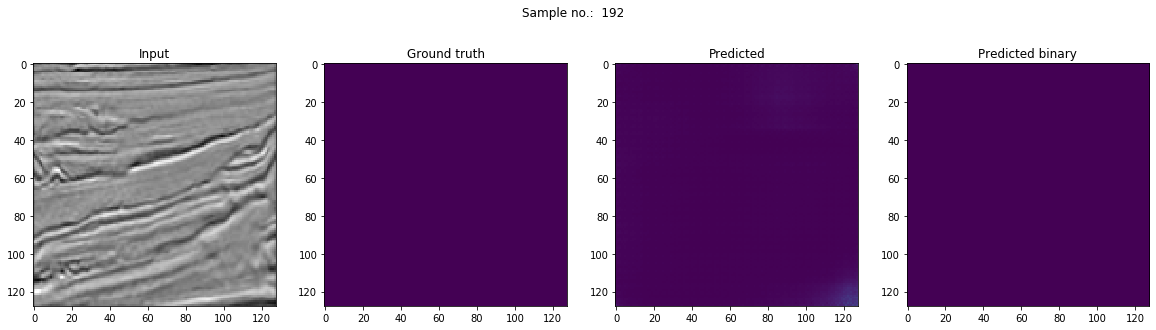

In [99]:
# Check if training data looks all right
plot_prediction(X_train, y_train, preds_train_std_no_skip, preds_train_t_std_no_skip)

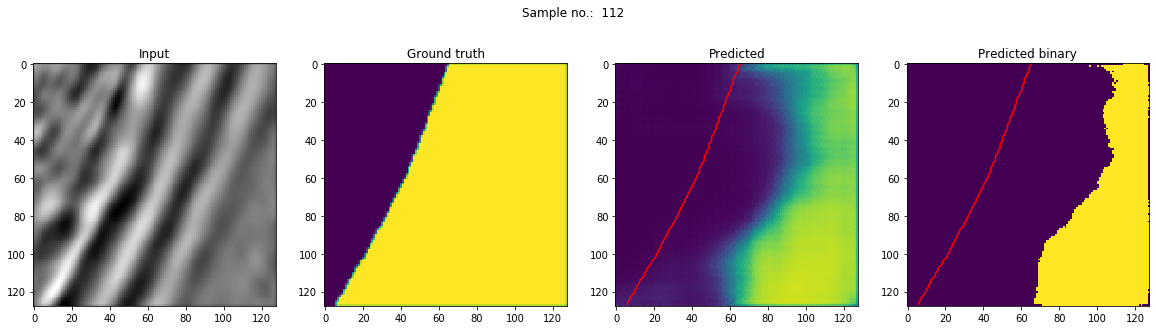

In [100]:
# Check if valid data looks all right
plot_prediction(X_valid, y_valid, preds_val_std_no_skip, preds_val_t_std_no_skip)

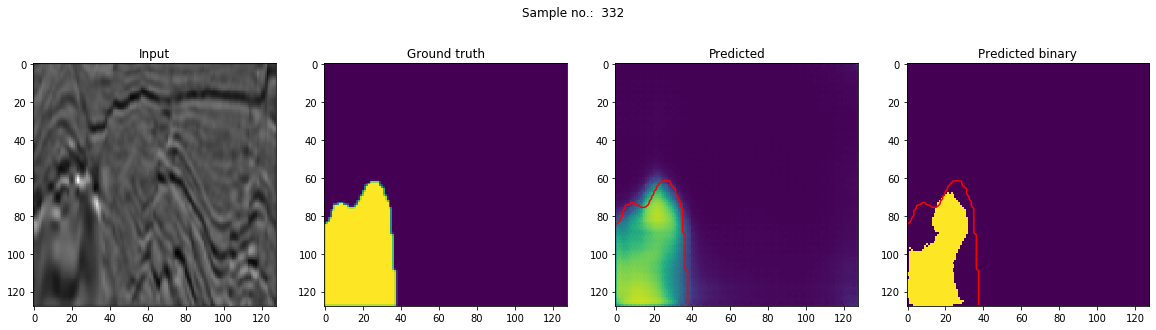

In [101]:
# Check if valid data looks all right
plot_prediction(X_test, y_test, preds_test_std_no_skip, preds_test_t_std_no_skip)

##U-Net-Modell mit Data Augmentation (h-Flip)

###Evaluation

In [0]:
# Load best model
model_h_flip.load_weights(filepath_h_flip)

In [103]:
# Evaluate on validation set
model_h_flip_eva_train = model_h_flip.evaluate(X_train, y_train, verbose=1)

2800/2800 [==============================] - 5s 2ms/step


In [104]:
# Evaluate on validation set
model_h_flip_eva_valid = model_h_flip.evaluate(X_valid, y_valid, verbose=1)

800/800 [==============================] - 1s 2ms/step


In [105]:
# Evaluate on test set
model_h_flip_eva_test = model_h_flip.evaluate(X_test, y_test, verbose=1)

400/400 [==============================] - 1s 2ms/step


In [106]:
# Predict on train, val and test
preds_train_h_flip = model_h_flip.predict(X_train, verbose=1)
preds_val_h_flip = model_h_flip.predict(X_valid, verbose=1)
preds_test_h_flip = model_h_flip.predict(X_test, verbose=1)

400/400 [==============================] - 0s 657us/step


###Threshold-Optimierung

In [0]:
thresholds_h_flip = np.linspace(0, 1 ,50)

In [108]:
ious_h_flip = np.array([iou_metric_batch(y_valid, np.int32(preds_val_h_flip > threshold)) for threshold in tqdm_notebook(thresholds_h_flip)])
threshold_best_index_h_flip = np.argmax(ious_h_flip[9:-10]) + 9
iou_best_h_flip = ious_h_flip[threshold_best_index_h_flip]
threshold_best_h_flip = thresholds_h_flip[threshold_best_index_h_flip]

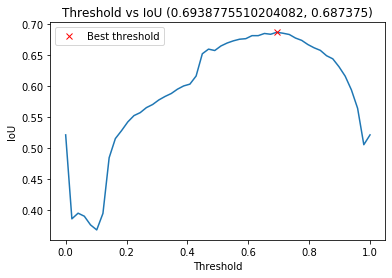

In [109]:
plot_thresholds(thresholds_h_flip, threshold_best_h_flip, ious_h_flip, iou_best_h_flip)

In [0]:
# Threshold predictions
preds_train_h_flip_t = (preds_train_h_flip > threshold_best_h_flip).astype(np.uint8)
preds_val_h_flip_t = (preds_val_h_flip > threshold_best_h_flip).astype(np.uint8)
preds_test_h_flip_t = (preds_test_h_flip > threshold_best_h_flip).astype(np.uint8)

###Beispielhafte Ausgabe der Vorhersagen

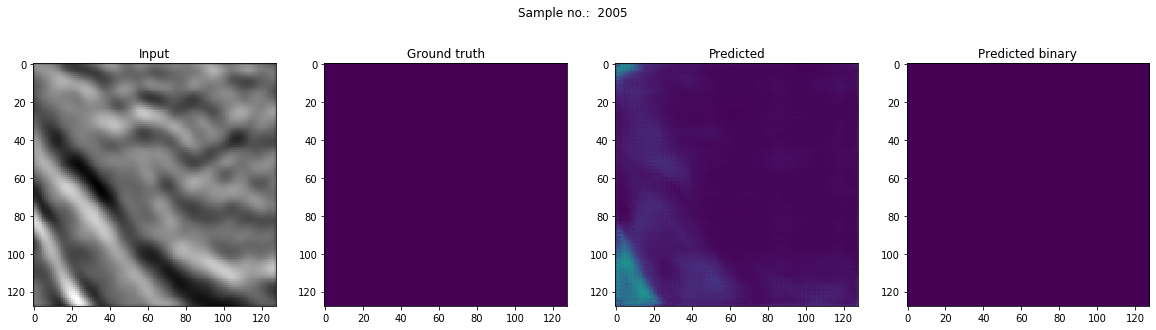

In [111]:
# Check if training data looks all right
plot_prediction(X_train, y_train, preds_train_h_flip, preds_train_h_flip_t)

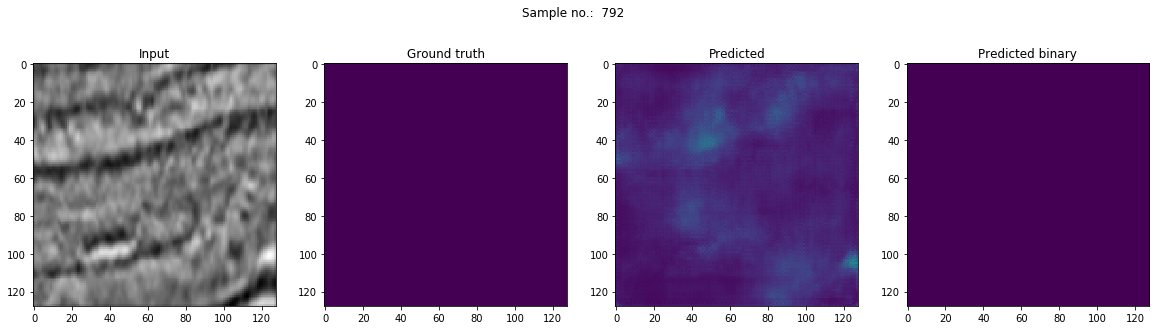

In [112]:
# Check if valid data looks all right
plot_prediction(X_valid, y_valid, preds_val_h_flip, preds_val_h_flip_t)

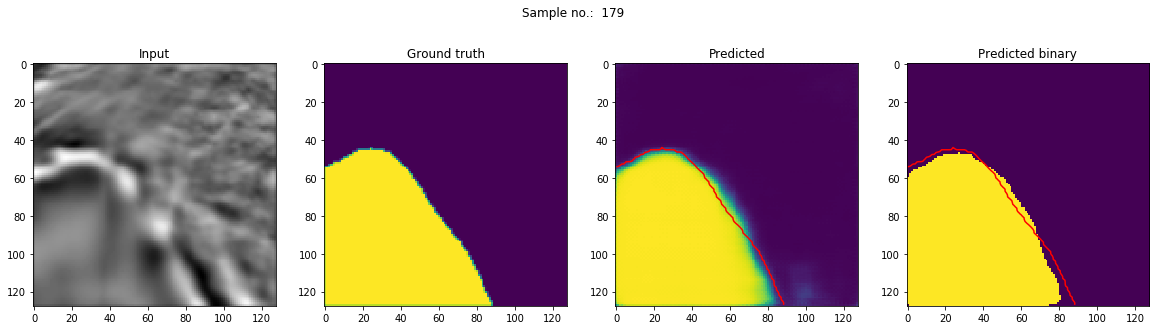

In [113]:
# Check if test data looks all right
plot_prediction(X_test, y_test, preds_test_h_flip, preds_test_h_flip_t)

##U-Net-Modell mit Data Augmentation (v-Flip)

###Evaluation

In [0]:
# Load best model
model_v_flip.load_weights(filepath_v_flip)

In [115]:
# Evaluate on validation set
model_v_flip_eva_train = model_v_flip.evaluate(X_train, y_train, verbose=1)

2800/2800 [==============================] - 4s 2ms/step


In [116]:
# Evaluate on validation set
model_v_flip_eva_valid = model_v_flip.evaluate(X_valid, y_valid, verbose=1)

800/800 [==============================] - 1s 2ms/step


In [117]:
# Evaluate on test set
model_v_flip_eva_test = model_v_flip.evaluate(X_test, y_test, verbose=1)

400/400 [==============================] - 1s 2ms/step


In [118]:
# Predict on train, val and test
preds_train_v_flip = model_v_flip.predict(X_train, verbose=1)
preds_val_v_flip = model_v_flip.predict(X_valid, verbose=1)
preds_test_v_flip = model_v_flip.predict(X_test, verbose=1)

400/400 [==============================] - 0s 668us/step


###Threshold-Optimierung

In [0]:
thresholds_v_flip = np.linspace(0, 1 ,50)

In [120]:
ious_v_flip = np.array([iou_metric_batch(y_valid, np.int32(preds_val_v_flip > threshold)) for threshold in tqdm_notebook(thresholds_v_flip)])
threshold_best_index_v_flip = np.argmax(ious_v_flip[9:-10]) + 9
iou_best_v_flip = ious_v_flip[threshold_best_index_v_flip]
threshold_best_v_flip = thresholds_v_flip[threshold_best_index_v_flip]

In [0]:
# Threshold predictions
preds_train_v_flip_t = (preds_train_v_flip > threshold_best_v_flip).astype(np.uint8)
preds_val_v_flip_t = (preds_val_v_flip > threshold_best_v_flip).astype(np.uint8)
preds_test_v_flip_t = (preds_test_v_flip > threshold_best_v_flip).astype(np.uint8)

###Beispielhafte Ausgabe der Vorhersagen

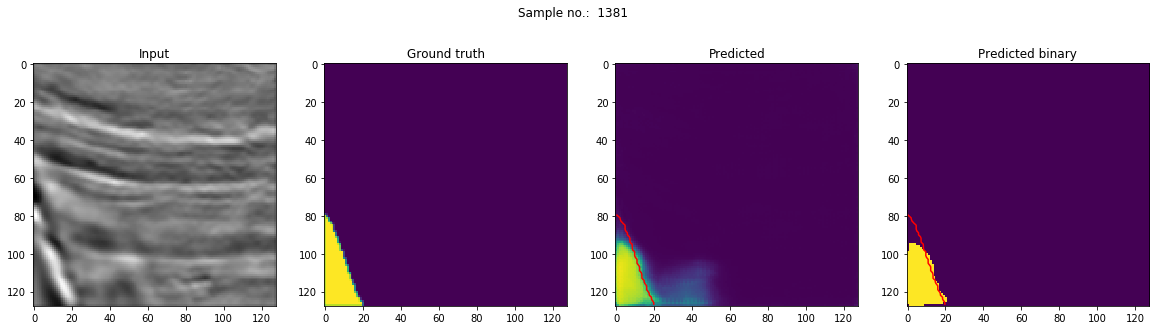

In [122]:
# Check if training data looks all right
plot_prediction(X_train, y_train, preds_train_v_flip, preds_train_v_flip_t)

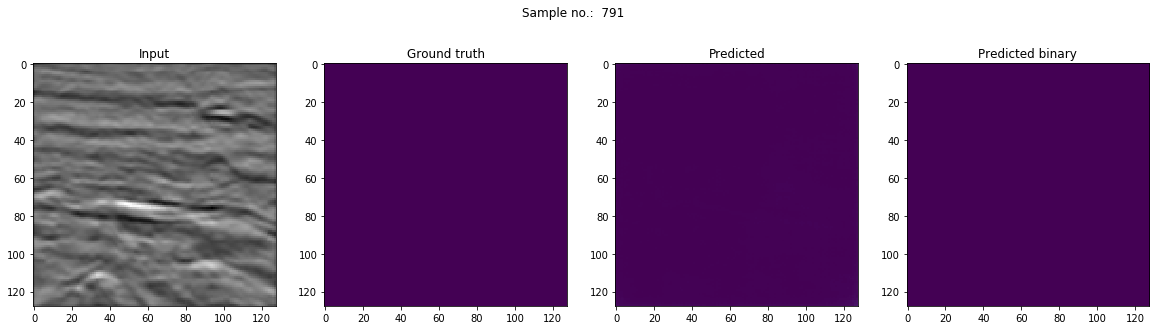

In [123]:
# Check if valid data looks all right
plot_prediction(X_valid, y_valid, preds_val_v_flip, preds_val_v_flip_t)

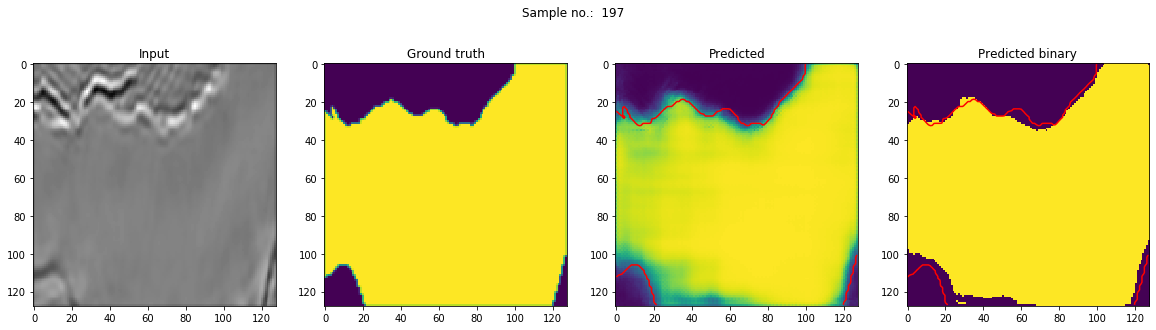

In [124]:
# Check if test data looks all right
plot_prediction(X_test, y_test, preds_test_v_flip, preds_test_v_flip_t)

##Vergleich der U-Net-Modelle

### Trainingsdaten

In [125]:
pip install beautifultable

In [0]:
from beautifultable import BeautifulTable

In [127]:
table_train = BeautifulTable()
table_train.column_headers = ["U-Net-Model", model_std.metrics_names[0], model_std.metrics_names[1]]
table_train.append_row(["std", model_std_eva_train[0], model_std_eva_train[1]])
table_train.append_row(["std_no_skip", model_std_no_skip_eva_train[0], model_std_no_skip_eva_train[1]])
table_train.append_row(["h-flip", model_h_flip_eva_train[0], model_h_flip_eva_train[1]])
table_train.append_row(["v-flip", model_v_flip_eva_train[0], model_v_flip_eva_train[1]])
print(table_train)

+-------------+-------+----------+
| U-Net-Model | loss  | mean_iou |
+-------------+-------+----------+
|     std     | 0.108 |  0.784   |
+-------------+-------+----------+
| std_no_skip | 0.111 |  0.786   |
+-------------+-------+----------+
|   h-flip    | 0.161 |  0.764   |
+-------------+-------+----------+
|   v-flip    | 0.126 |  0.765   |
+-------------+-------+----------+


###Validierungsdaten

In [128]:
table_valid = BeautifulTable()
table_valid.column_headers = ["U-Net-Model", model_std.metrics_names[0], model_std.metrics_names[1]]
table_valid.append_row(["std", model_std_eva_valid[0], model_std_eva_valid[1]])
table_valid.append_row(["std_no_skip", model_std_no_skip_eva_valid[0], model_std_no_skip_eva_valid[1]])
table_valid.append_row(["h-flip", model_h_flip_eva_valid[0], model_h_flip_eva_valid[1]])
table_valid.append_row(["v-flip", model_v_flip_eva_valid[0], model_v_flip_eva_valid[1]])
print(table_valid)

+-------------+-------+----------+
| U-Net-Model | loss  | mean_iou |
+-------------+-------+----------+
|     std     | 0.14  |  0.785   |
+-------------+-------+----------+
| std_no_skip | 0.151 |  0.787   |
+-------------+-------+----------+
|   h-flip    | 0.17  |  0.765   |
+-------------+-------+----------+
|   v-flip    | 0.148 |  0.766   |
+-------------+-------+----------+


###Testdaten

In [129]:
table_test = BeautifulTable()
table_test.column_headers = ["U-Net-Model", model_std.metrics_names[0], model_std.metrics_names[1]]
table_test.append_row(["std", model_std_eva_test[0], model_std_eva_test[1]])
table_test.append_row(["std_no_skip", model_std_no_skip_eva_test[0], model_std_no_skip_eva_test[1]])
table_test.append_row(["h-flip", model_h_flip_eva_test[0], model_h_flip_eva_test[1]])
table_test.append_row(["v-flip", model_v_flip_eva_test[0], model_v_flip_eva_test[1]])
print(table_test)

+-------------+-------+----------+
| U-Net-Model | loss  | mean_iou |
+-------------+-------+----------+
|     std     | 0.14  |  0.785   |
+-------------+-------+----------+
| std_no_skip | 0.151 |  0.787   |
+-------------+-------+----------+
|   h-flip    | 0.166 |  0.765   |
+-------------+-------+----------+
|   v-flip    | 0.146 |  0.766   |
+-------------+-------+----------+


#Zusammenfassung

- zu Grunde liegende Daten können fehlerhaft sein (Masken)
- ein Modell kann innerhalb weniger Minuten (ca. 10min) trainiert werden
- das Standardmodell (std) lieferte bei den Testdaten das beste Ergebnis (mean_IoU von ca. 80%, beste Ergebnisse der Kaggle-Challange liegen im Bereich um 90%)
- überaschenderweise schneidet das Modell ohne Skip Connection (std_no_skip) nur unwesentlich schlechter als das Standardmodell (std) ab (Runtime zurücksetzen und erneute Trainieren, dann wird es deutlich)
- die Benutzung von Data Augmentation erzielte nicht die erwartete Verbesserung (es müssten weitere Verfahren ausprobiert werden, Variation Parameter)

#Quellen

- https://github.com/llSourcell/Kaggle_Challenge_LIVE/blob/master/salt_identification.ipynb
- https://www.youtube.com/watch?v=jm8IBBKNeA4
- https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/ 
- https://www.codeastar.com/u-net-object-detection-iou/
- https://towardsdatascience.com/unet-line-by-line-explanation-9b191c76baf5
- https://towardsdatascience.com/u-net-b229b32b4a71
- https://medium.com/activating-robotic-minds/up-sampling-with-transposed-convolution-9ae4f2df52d0
- https://github.com/vdumoulin/conv_arithmetic
- https://www.depends-on-the-definition.com/test-time-augmentation-keras/
- https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
- https://www.geeksforgeeks.org/python-data-augmentation/